In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [42]:
import warnings
warnings.filterwarnings("ignore")

In [43]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, f1_score
from sklearn.preprocessing import FunctionTransformer
from lightgbm import LGBMClassifier

In [56]:
music_data = pd.read_csv('../data/audio_data_genre_augmented.csv') 

In [57]:
def plot_learning_curve(estimator, title, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes
    )
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    
    plt.legend(loc="best")
    return plt

In [88]:
numerical_imputer = SimpleImputer(strategy='mean')
categorical_imputer = SimpleImputer(strategy='most_frequent')

feature_selector = SelectFromModel(estimator=LGBMClassifier(boosting_type='gbdt',
                                                            class_weight=None,
                                                            colsample_bytree=1.0,
                                                            importance_type='split',
                                                            learning_rate=0.1,
                                                            max_depth=-1,
                                                            min_child_samples=20,
                                                            min_child_weight=0.001,
                                                            min_split_gain=0.0,
                                                            n_estimators=100,
                                                            num_leaves=31,
                                                            reg_alpha=0.0,
                                                            reg_lambda=0.0,
                                                            subsample=1.0,
                                                            subsample_for_bin=200000,
                                                            subsample_freq=0, 
                                                            verbosity=-1),
                                    max_features=13)

trained_model = LGBMClassifier(boosting_type='gbdt',
                               class_weight=None,
                               colsample_bytree=1.0,
                               importance_type='split',
                               learning_rate=0.01,
                               max_depth=-1,
                               min_child_samples=20,
                               min_child_weight=0.001,
                               min_split_gain=0.0,
                               n_estimators=1000,
                               n_jobs=-1,
                               num_leaves=127,
                               objective='multiclass',
                               random_state=2114,
                               reg_alpha=0.0,
                               reg_lambda=0.0,
                               subsample=1.0,
                               subsample_for_bin=200000,
                               subsample_freq=0,
                               verbosity=-1,
                               max_bin=255)

pipeline = Pipeline(steps=[
    ('numerical_imputer', FunctionTransformer(func=lambda X: numerical_imputer.fit_transform(X))),
    ('categorical_imputer', FunctionTransformer(func=lambda X: categorical_imputer.fit_transform(X))),
    ('feature_selection', feature_selector),
    ('trained_model', trained_model)
])

In [89]:
X = music_data.drop("label", axis=1) 
y = music_data["label"]  

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [90]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('numerical_imputer',
                 FunctionTransformer(func=<function <lambda> at 0x0000017D9032E7A0>)),
                ('categorical_imputer',
                 FunctionTransformer(func=<function <lambda> at 0x0000017D9C3E3F40>)),
                ('feature_selection',
                 SelectFromModel(estimator=LGBMClassifier(verbosity=-1),
                                 max_features=13)),
                ('trained_model',
                 LGBMClassifier(learning_rate=0.01, max_bin=255,
                                n_estimators=1000, n_jobs=-1, num_leaves=127,
                                objective='multiclass', random_state=2114,
                                verbosity=-1))])

In [95]:
y_pred = pipeline.predict(X_test)

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.83      0.89        29
           1       0.90      1.00      0.95        27
           2       0.72      0.90      0.80        31
           3       0.89      0.83      0.86        30
           4       0.80      0.89      0.84        27
           5       0.89      0.80      0.84        30
           6       0.97      0.97      0.97        30
           7       0.89      0.92      0.91        26
           8       0.92      0.79      0.85        28
           9       0.93      0.87      0.90        31

    accuracy                           0.88       289
   macro avg       0.89      0.88      0.88       289
weighted avg       0.89      0.88      0.88       289



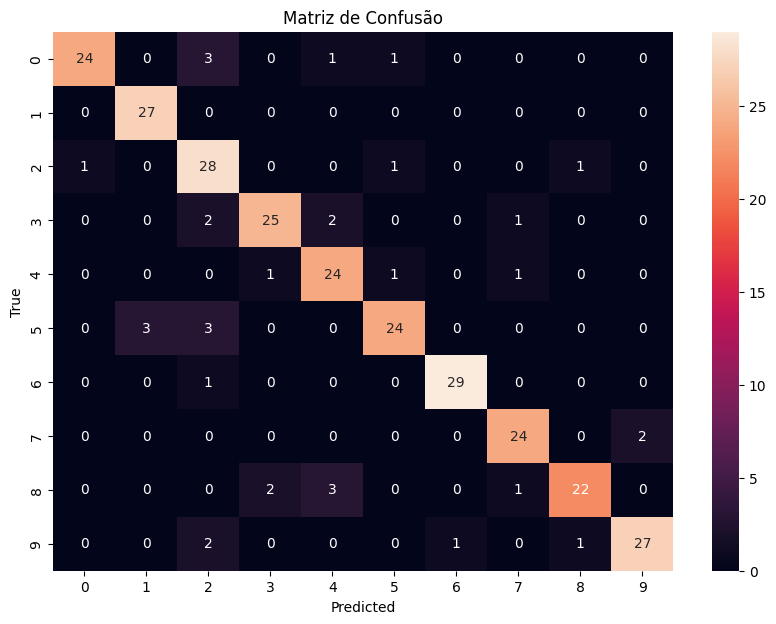

In [97]:
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Matriz de Confusão')
plt.show()

<module 'matplotlib.pyplot' from 'c:\\Users\\pedro.mira\\AppData\\Local\\miniconda3\\envs\\music_genre\\lib\\site-packages\\matplotlib\\pyplot.py'>

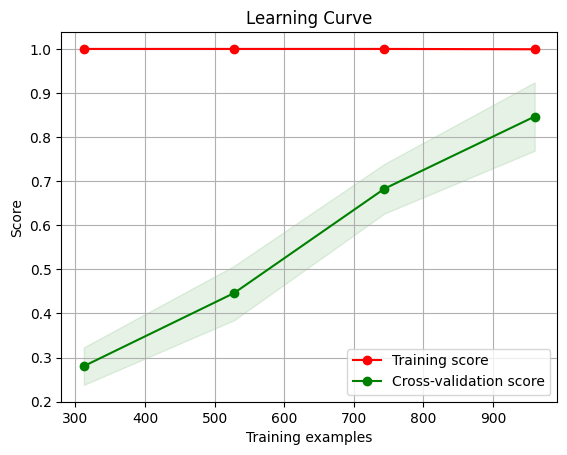

In [98]:
plot_learning_curve(pipeline, "Learning Curve", X, y, cv=3)